# Project 4


Classification/prediction of text reviews is a useful tool for many different fields and is a perfect application of Natural Language Processing (NLP) techniques within Machine Learning/Deep Learning.  

In this case, we will attend to video game reviews on the Steam platform (a digital distribution service and storefront developed by Valve).  Launched in 2003, users are able to purchase and download games from Steam, as well as use their cloud storage to backup saved games for use across multiple devices.  As of March 29, 2022, Steam reports over 27 million concurrent users at peak logged in to their service, with over 120 million users total.   



Currently, users are able to supply "would recommend"/"would not recommend" binary ratings, along with text reviews of games on Steam.  This provides us with a data set of labeled data from which to begin.

Stakeholders in this process include (but aren't limited to)
- Valve (or other digital distributors, e.g. Epic Games, Apple App Store, Google Play), 
- video game developers/publishers, 
- video game consumers (including reviewers, critics, players, streamers, etc.), 
- computer hardware manufacturers (knowledge about what games are popular could drive  video card architecture, e.g.)  
- cultural linguists (due to the nuanced and specialized vernacular exhibited by video gaming communities).

Business problems that such an investigation could illuminate include:
- validation of new ratings (i.e. checking consistency between user text and user binary rating).  This could be helpful for several reasons.  
    - Prompting users to double-check that they provided the intended binary rating, if their text review seems inconsistent.  
    - Notifying Valve of potential abuse/manipulation of the rating system, in the event that users are repeatedly providing inconsistent rating/review combinations.  
- automatically applying a binary rating to unlabeled reviews, which might be accessible, for example, from scrubbing the web for other game reviews.  

- generating a more nuanced rating number for each review than just 0 or 1; this could be more representative when aggregating the reviews.  
    - For example, a game which received three reviews, two that were just slightly negative and one very positive would receive binary scores of 0, 0, and 1, while receiving nuanced scores of .4, .4, and .9.  Another game could receive two very negative reviews and one slightly positive one and receive the same binary scores, (0, 0, 1) but receive different nuanced scores, .1, .1, and .6.  In aggregate, the binary system would rank these games the same, but would give a higher average nuanced rating to the former game.



In [1]:
SINGLE_SOURCE = True

In [2]:
import xgboost as xgb

In [3]:
from xgboost import XGBClassifier

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
#Ensure to download spacy and the corresponding package
# pip install -U spacy
# python -m spacy download en_core_web_sm

import spacy
spacy_nlp = spacy.load('en_core_web_sm')

In [6]:
import matplotlib.pyplot as plt 
import re 
#import spacy ##do we need this?
import seaborn as sns 

import pandas as pd
import numpy as np
from collections import Counter

#must ensure conda install py-xgboost
#import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D, RepeatVector
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from wordcloud import WordCloud
import random

Loading Data

In [7]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')


In [7]:
train_df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [8]:
test_df.head()

,review_id,title,year,user_review
0,1603,Counter-Strike: Global Offensive,2015.0,"Nice graphics, new maps, weapons and models. B..."
1,1604,Counter-Strike: Global Offensive,2018.0,I would not recommend getting into this at its...
2,1605,Counter-Strike: Global Offensive,2018.0,Edit 11/12/18I have tried playing CS:GO recent...
3,1606,Counter-Strike: Global Offensive,2015.0,The game is great. But the community is the wo...
4,1607,Counter-Strike: Global Offensive,2015.0,I thank TrulyRazor for buying this for me a lo...


In [9]:
train_df.sample(5)

,review_id,title,year,user_review,user_suggestion
301,302,Spooky's Jump Scare Mansion,2015.0,Early Access ReviewThis is a smart little game...,1
9208,12218,PlanetSide 2,2015.0,"*Static, sounds of gunfire, and artillery fire...",1
12034,17531,Bless Online,2018.0,Early Access Reviewthe game was fun at the beg...,0
9671,13255,Realm of the Mad God,2015.0,This game is really ♥♥♥♥ing fun and addicting ...,1
12660,18157,RaceRoom Racing Experience,2018.0,"I've put a few laps down in this sim, and thro...",1


In [10]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8045 entries, 0 to 8044
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    8045 non-null   int64  
 1   title        8045 non-null   object 
 2   year         7978 non-null   float64
 3   user_review  8045 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 251.5+ KB


None

In [11]:
display(train_df.isna().sum())
display(test_df.isna().sum())
#year has some invalid entries, but we won't be using those.

review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64

review_id       0
title           0
year           67
user_review     0
dtype: int64

In [12]:
#check distribution of value counts
train_df['user_suggestion'].value_counts()
#so there is a little imbalance, we could ignore it or rebalance by resampling.
#see # https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/#:~:text=Class%20Imbalance%20is%20a%20common,Spam%20filtering

1    9968
0    7526
Name: user_suggestion, dtype: int64

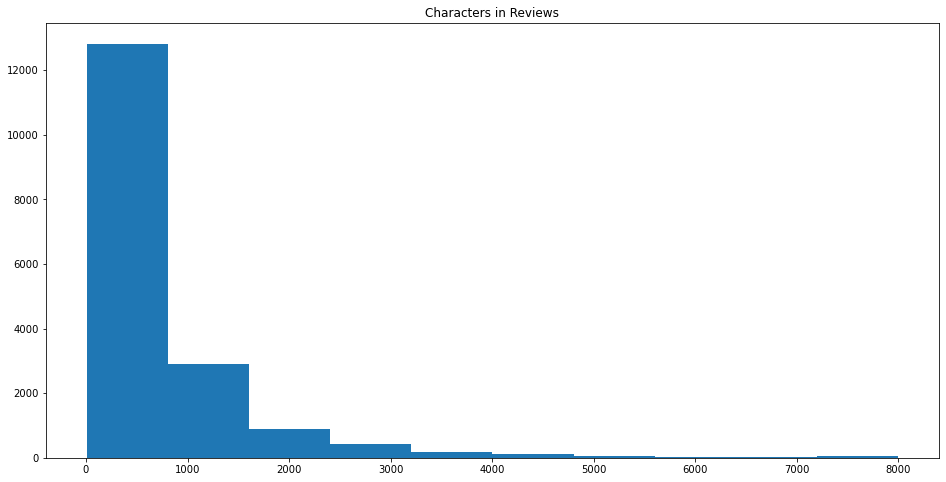

In [13]:
#Number of characters
class_len = train_df['user_review'].str.len()

plt.figure(figsize=(16,8))
plt.hist(class_len)
plt.title('Characters in Reviews')

plt.show()

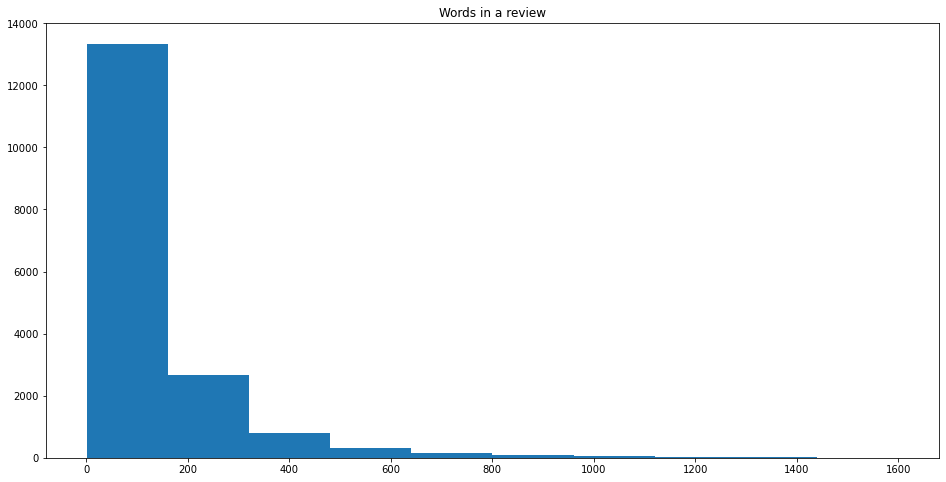

In [14]:
class_len = train_df['user_review'].str.split().map(lambda text: len(text))

plt.figure(figsize=(16,8))
plt.hist(class_len)
plt.title('Words in a review')

plt.show()

In [9]:
import nltk 
from nltk.corpus import stopwords 
import string
import collections

STOPWORDS = stopwords.words('english')
print(STOPWORDS)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
def create_corpus():
    corpus = []
    
    for sentence in train_df['user_review'].str.split():
        for word in sentence:
            corpus.append(word.lower())
    
    return corpus

In [11]:
corpus = create_corpus()

<BarContainer object of 20 artists>

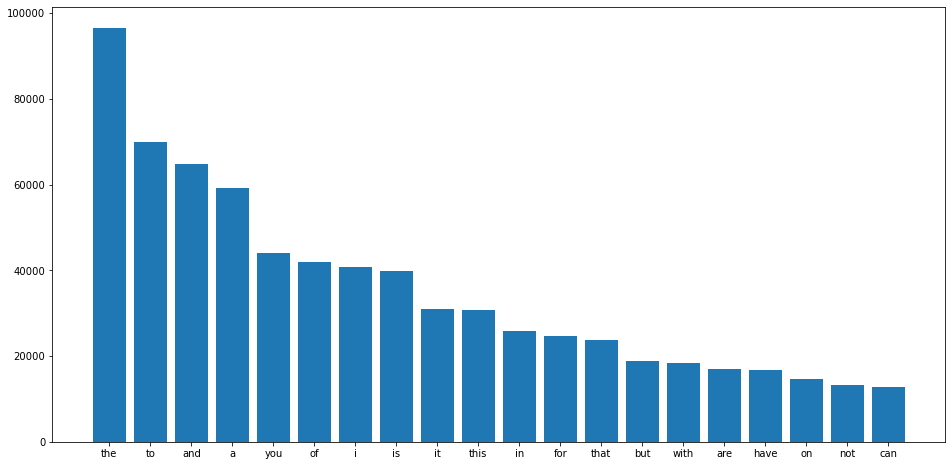

In [12]:
#Look at top 20 most common stopwords in our data
#corpus = create_corpus()
dic = collections.defaultdict(int)

for word in corpus:
    if word in STOPWORDS:
        dic[word] += 1

x, y = zip(*sorted(dic.items(), key=lambda word: word[1], reverse=True)[:20])

plt.figure(figsize=(16, 8))
plt.bar(x, y)

<BarContainer object of 20 artists>

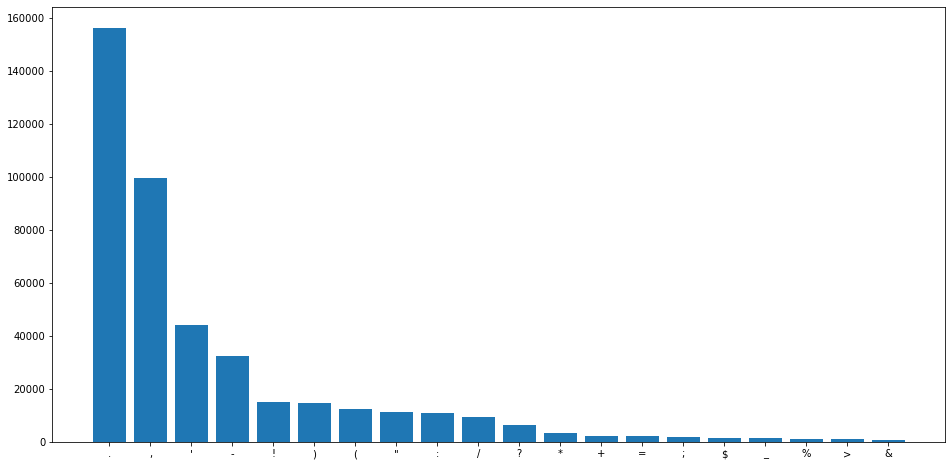

In [12]:
#Now the most common punctuation
corpus = create_corpus()
dic = collections.defaultdict(int)

for word in corpus:
    for char in word:
        if char in string.punctuation:
            dic[char] += 1

x, y = zip(*sorted(dic.items(), key=lambda word: word[1], reverse=True)[:20])

plt.figure(figsize=(16,8))
plt.bar(x, y)

In [13]:
#Plot the most common words in review
#corpus = create_corpus()
counter = collections.Counter(corpus)
most_common = counter.most_common()

x, y = [], []

for word, count in most_common[:50]:
    if word not in STOPWORDS:
        x.append(word)
        y.append(count)

<AxesSubplot:>

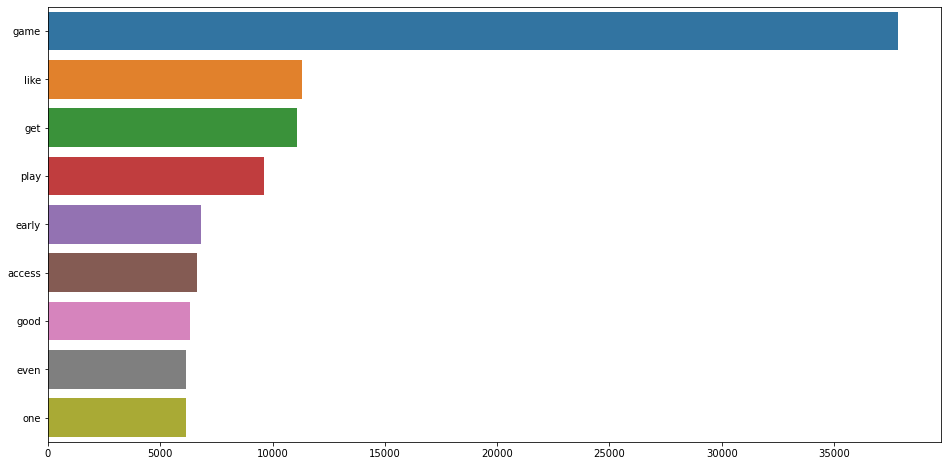

In [14]:
#import seaborn as sns 

plt.figure(figsize=(16, 8))
sns.barplot(x=y, y=x)

In [15]:
#Add a color theme for the following wordcloud:
def purple_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl({}, {}%, {}%)".format(random.randint(220,330), random.randint(60, 80), random.randint(60, 80))
            #"hsl(0, 0%%, %d%%)" % random.randint(60, 100)


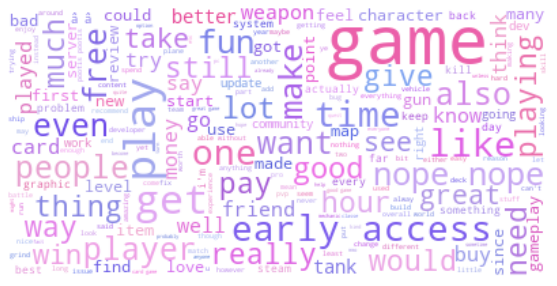

In [16]:
#Everybody loves a good word cloud
from wordcloud import WordCloud

all_words = ' '.join(corpus) 

wordcloud = WordCloud(max_font_size=50, background_color='white', color_func=purple_color_func, stopwords=STOPWORDS).generate(all_words)

plt.figure(figsize=(15,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

# Some typical preprocessing:
- Apply lowercase  
- Remove punctuation  
- Remove numbers  
- Remove stopwords  
- Remove white spaces  
- Apply lemmatization  

- and stemming???

In [12]:
#Apply lowercase
train_df['review_cleaned'] = train_df['user_review'].apply(lambda text: text.lower())

#Remove punctuation
# def remove_punctuation(sentence):
#     return ''.join([word for word in str(sentence) if word not in string.punctuation])

'''import string
a_string = '!hi. wh?at is the weat[h]er lik?e.'
new_string = a_string.translate(str.maketrans('', '', string.punctuation))
print(new_string)'''
import string
def remove_punctuation(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))
    
train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_punctuation(text))

#Remove numbers
def remove_numbers(sentence):
    return re.sub(r'\d+', '', sentence)

train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_numbers(text))

#Remove stopwords
def remove_stopwords(sentence):
    return ' '.join([word for word in str(sentence).split() if word not in STOPWORDS])
    
train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_stopwords(text))

#Remove white spaces
def remove_spaces(sentence):
    return re.sub(r'\s+', ' ', sentence).strip()

train_df['review_cleaned'] = train_df['review_cleaned'].apply(lambda text: remove_spaces(text))

if not SINGLE_SOURCE:
    #Apply lemmatization
    spacy_lem = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    def lemmatizer_doc(sentence):
        doc = spacy_lem(sentence)
        new_sentence = [token.lemma_ for token in doc if token.is_alpha]  
        return ' '.join(new_sentence)

    train_df['review_lemma'] = train_df['review_cleaned'].apply(lambda text: lemmatizer_doc(text))

    # Apply stemming
    def stemmer(sentence):
        ps = PorterStemmer()
        return ps.stem(sentence)

    train_df['review_stem'] = train_df['review_cleaned'].apply(lambda text: stemmer(text))

In [13]:
INSPECT_ROW = 3
print('Original review\n', train_df['user_review'].iloc[INSPECT_ROW])
if not SINGLE_SOURCE:
    print('\nReview clean\n',train_df['review_cleaned'].iloc[INSPECT_ROW])
    print('\nReview lemmatized\n',train_df['review_lemma'].iloc[INSPECT_ROW])
    print('\nReview stemmed\n',train_df['review_stem'].iloc[INSPECT_ROW])

Original review
 Great game, fun and colorful and all that.A side note, though: When are we getting windowed mode? My computer hates fullscreen so.... yeah. The computer doesn't like to run this. Shame, because this is really enjoyable. But until then, I guess I'll settle for more Skyrim. Cheers!


We see that the three "cleaned" columns contain noticeable differences.  Although lemmatization sounds like an ideal process to perform in general, familiar text, it may encounter some difficulties when we apply it to informal or vernacular text (which we see extensively in Steam reviews).  Let's process all three cleaned columns into a comparison model later and see how they do.

In [14]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train_df.user_suggestion.values)


In [15]:
if SINGLE_SOURCE:
    xtrain, xvalid, ytrain, yvalid = train_test_split(train_df.user_review.values, y, 
                                                      stratify=y, 
                                                      random_state=42, 
                                                      test_size=0.1, shuffle=True)
    xtrain_raw, xvalid_raw, ytrain_raw, yvalid_raw = xtrain, xvalid, ytrain, yvalid
else:
    xtrain_raw, xvalid_raw, ytrain_raw, yvalid_raw = train_test_split(train_df.user_review.values, y, 
                                                      stratify=y, 
                                                      random_state=42, 
                                                      test_size=0.1, shuffle=True)
    xtrain_cln, xvalid_cln, ytrain_cln, yvalid_cln = train_test_split(train_df.review_cleaned.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
    xtrain_lem, xvalid_lem, ytrain_lem, yvalid_lem = train_test_split(train_df.review_lemma.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
    xtrain_stm, xvalid_stm, ytrain_stm, yvalid_stm = train_test_split(train_df.review_stem.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
    suffixes = ['_raw', '_cln', '_lem', '_stm']

# Metrics
Different metrics inform our analysis in their own way.  There are some NLP projects that prioritize log-loss, AUC, f1, accuracy, and others. 

Part of our choice depends on the following question - should this analysis investigate or explore the level of nuance of a review?  Or should the end goal be simply to predict positivity/negativity well?  

- Log-loss is a highly useful metric for evaluating probability.  In this case, our models will be estimating a probability of being a positive review along the way (or, arguably, the level of positive sentiment in the review), so this will be a contender.  This measure will continue to give feedback throughout tuning.

- AUC (and ROC curves) measure the ability for a model to separate labels correctly into two distinct categories.  That is included in our goal, so this is also a contender metric that we will look at.  ROC curves can serve as a useful visualization for comparison of different models.  They are also useful when there is a mostly-even distribution in labels (which is what we have).  If they were not even, a precision-recall curve would be more useful.

- f1 is a blend of recall and precision, and is worth consideration.

- Accuracy will have less "gray area," and won't really be able to consider the nuance (e.g. a lukewarm review might give .6 positivity), but if our priority at the end of the line is to correctly predict positive/negative (and ignore the degree of each), then this could be considered.  This measure will likely give less feedback during tuning, as once a prediction meets the right label, it is considered good enough.



In [16]:
def score_report(ytrue, preds, bin_preds):
    print ("Model Log-loss: %0.3f " % log_loss(ytrue, predictions))
    print ("Model F1 score: %0.3f " % f1_score(ytrue, bin_preds))
    print ("Model Accuracy score: %0.3f " % accuracy_score(ytrue, bin_preds))
    #auc/roc
    majority = Counter(ytrue).most_common(1)[0][0]
    ns_probs = [majority for _ in range(len(ytrue))]
    ns_auc = roc_auc_score(ytrue, ns_probs)
    m_auc = roc_auc_score(ytrue, preds[:,1])#predictions
    print('Naive ROC AUC=%.3f' % (ns_auc))
    print('Model ROC AUC=%.3f' % (m_auc))
    ns_fpr, ns_tpr, _ = roc_curve(ytrue, ns_probs)
    m_fpr, m_tpr, _ = roc_curve(ytrue, preds[:,1])
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(m_fpr, m_tpr, marker='.', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    


# Starting Models
- TF-IDF
- Logistic Regression

In [17]:
splits = ['_raw', '_cln', '_lem', '_stm']
def select_split(suffix):
    xtrain, xvalid, ytrain, yvalid = eval('xtrain'+suffix+', '+ 'xvalid'+suffix+', '+ 'ytrain'+suffix+', '+ 'yvalid'+suffix)
    return xtrain, xvalid, ytrain, yvalid


# On the raw user reviews

In [18]:
xtrain, xvalid, ytrain, yvalid = select_split(splits[0])

In [19]:
# Following features are common starting points and work well in most cases.
# tfv = TfidfVectorizer(min_df=3,  max_features=None, 
#             strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
#             ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
#             stop_words = 'english')

tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

Model Log-loss: 0.356 
Model F1 score: 0.878 
Model Accuracy score: 0.857 
Naive ROC AUC=0.500
Model ROC AUC=0.934


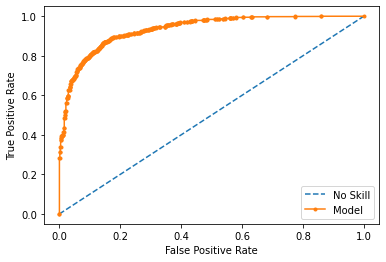

In [39]:
# Fit a simple Logistic Regression on TF-IDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)
# sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
#from sklearn.metrics import log_loss, f1_score, accuracy_score

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

score_report(yvalid, predictions, bin_preds)
#Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
#binary outputs of .predict.  
#We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
#descriptive of what the regression is doing.


Model Log-loss: 0.384 
Model F1 score: 0.879 
Model Accuracy score: 0.858 
Naive ROC AUC=0.500
Model ROC AUC=0.934


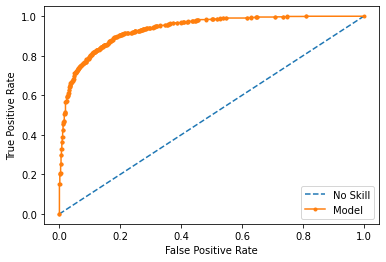

In [44]:
#Raw plus
xtrain, xvalid, ytrain, yvalid = select_split(splits[0])

# Following features are common starting points and work well in most cases.
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

#tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

# Fit a simple Logistic Regression on TF-IDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)
# sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
#from sklearn.metrics import log_loss, f1_score, accuracy_score

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

score_report(yvalid, predictions, bin_preds)
#Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
#binary outputs of .predict.  
#We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
#descriptive of what the regression is doing.


# On the cleaned reviews

Model Log-loss: 0.395 
Model F1 score: 0.871 
Model Accuracy score: 0.848 
Naive ROC AUC=0.500
Model ROC AUC=0.928


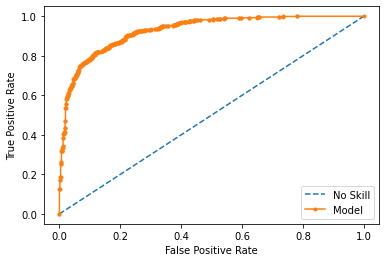

In [40]:
if not SINGLE_SOURCE:
    xtrain, xvalid, ytrain, yvalid = select_split(splits[1])
    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    # Fitting TF-IDF to both training and test sets (semi-supervised learning)
    tfv.fit(list(xtrain) + list(xvalid))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)

    #############

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

    score_report(yvalid, predictions, bin_preds)
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


# On the lemmatized reviews

Model Log-loss: 0.401 
Model F1 score: 0.865 
Model Accuracy score: 0.841 
Naive ROC AUC=0.500
Model ROC AUC=0.922


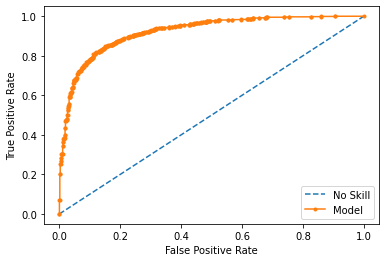

In [41]:
if not SINGLE_SOURCE:
    xtrain, xvalid, ytrain, yvalid = select_split(splits[2])
    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    # Fitting TF-IDF to both training and test sets (semi-supervised learning)
    tfv.fit(list(xtrain) + list(xvalid))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)

    #############

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

    score_report(yvalid, predictions, bin_preds)
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


# On the stemmed reviews

Model Log-loss: 0.397 
Model F1 score: 0.870 
Model Accuracy score: 0.847 
Naive ROC AUC=0.500
Model ROC AUC=0.927


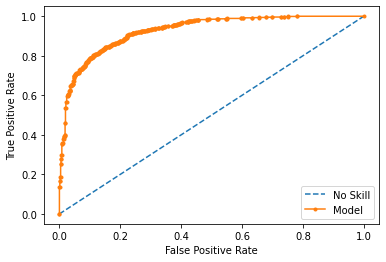

In [42]:
if not SINGLE_SOURCE:
    xtrain, xvalid, ytrain, yvalid = select_split(splits[3])
    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    # Fitting TF-IDF to both training and test sets (semi-supervised learning)
    tfv.fit(list(xtrain) + list(xvalid))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)

    #############

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

    score_report(yvalid, predictions, bin_preds)
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


Somewhat unexpectedly, the built-in processing in TfidfVectorizer works best on logistic regression. Whether stemming/lemmatization underperform because they aren't capturing vernacular is unclear, but we will proceed with it (rerunning that cell below to re-initialize all its variables).  


Model Log-loss: 0.384 
Model F1 score: 0.879 
Model Accuracy score: 0.858 
Naive ROC AUC=0.500
Model ROC AUC=0.934


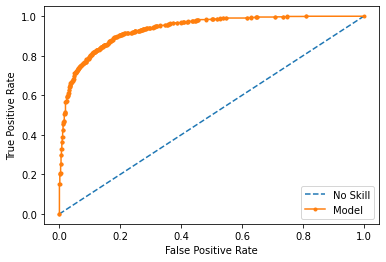

In [28]:
if not SINGLE_SOURCE:
    #Raw 
    suffix=0
    xtrain, xvalid, ytrain, yvalid = select_split(splits[0])

    # Following features are common starting points and work well in most cases.
    tfv = TfidfVectorizer(min_df=3,  max_features=None, 
                strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
                stop_words = 'english')

    #tfv = TfidfVectorizer()

    # Fitting TF-IDF to both training and test sets (semi-supervised learning)
    tfv.fit(list(xtrain) + list(xvalid))
    xtrain_tfv =  tfv.transform(xtrain) 
    xvalid_tfv = tfv.transform(xvalid)

    # Fit a simple Logistic Regression on TF-IDF
    clf = LogisticRegression(C=1.0)
    clf.fit(xtrain_tfv, ytrain)
    predictions = clf.predict_proba(xvalid_tfv)
    bin_preds = clf.predict(xvalid_tfv)
    # sklearn.metrics.log_loss(y_true, y_pred, *, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    #from sklearn.metrics import log_loss, f1_score, accuracy_score

    # print ("logloss: %0.3f " % log_loss(yvalid, predictions))
    # print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
    # print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

    score_report(yvalid, predictions, bin_preds)
    #Note, we want to be careful about applying accuracy/f1 here because those are classification metrics, and only apply to the
    #binary outputs of .predict.  
    #We can apply the predict_proba to get actual probabilities (i.e. before the softmax step) that are possibly more
    #descriptive of what the regression is doing.


# Word Counts - CountVectorizer

Instead of using TF-IDF, we can also use word counts as features. This can be done easily using CountVectorizer from scikit-learn.

In [22]:
xtrain, xvalid, ytrain, yvalid = select_split(splits[0])

ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [30]:
#checking out an arbitrary entry of that ctv
#xtrain_ctv[1,2]

Scores for simple Logistic Regression on counts on _raw data.
Model Log-loss: 0.449 
Model F1 score: 0.872 
Model Accuracy score: 0.851 
Naive ROC AUC=0.500
Model ROC AUC=0.920


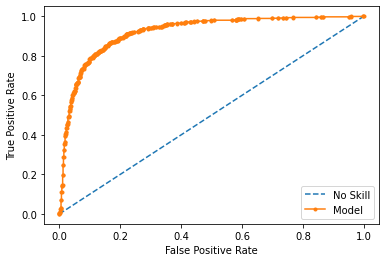

In [31]:
# Fit a simple Logistic Regression on those Counts
clf = LogisticRegression(C=1.0, max_iter=500,)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
bin_preds = clf.predict(xvalid_ctv)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for simple Logistic Regression on counts on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)

Ok, worse loss, f1, and accuracy.

In [78]:
if not SINGLE_SOURCE:
    #Looping through the 4 sets
    for suffix in range(len(splits)):
        xtrain, xvalid, ytrain, yvalid = select_split(splits[suffix])

        ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 3), stop_words = 'english')

        # Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
        ctv.fit(list(xtrain) + list(xvalid))
        xtrain_ctv =  ctv.transform(xtrain) 
        xvalid_ctv = ctv.transform(xvalid)

        # Fit a simple Logistic Regression on those Counts
        clf = LogisticRegression(C=1.0, max_iter=500,)
        clf.fit(xtrain_ctv, ytrain)
        predictions = clf.predict_proba(xvalid_ctv)
        bin_preds = clf.predict(xvalid_ctv)
        print('Scores for Count Vectorized Logistic Regression on {} data.'.format(splits[suffix]))
        score_report(yvalid, predictions, bin_preds)
    

Scores for simple Naive Bayes on TF-IDF on _raw data.
Model Log-loss: 0.400 
Model F1 score: 0.868 
Model Accuracy score: 0.836 
Naive ROC AUC=0.500
Model ROC AUC=0.930


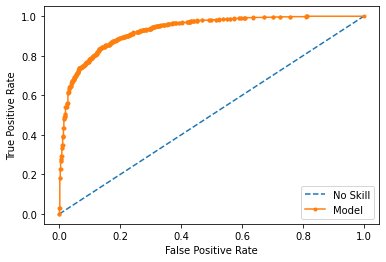

In [81]:
# Fit a simple Naive Bayes on TF-IDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
bin_preds = clf.predict(xvalid_tfv)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for simple Naive Bayes on TF-IDF on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)

What happens when we use this model on counts data instead?

Scores for simple Naive Bayes on Counts on _raw data.
Model Log-loss: 1.286 
Model F1 score: 0.876 
Model Accuracy score: 0.859 
Naive ROC AUC=0.500
Model ROC AUC=0.914


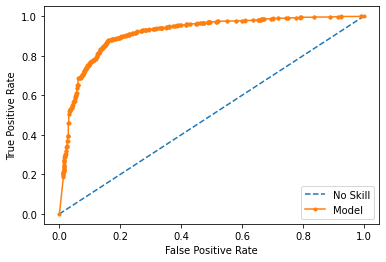

In [82]:
# Fit a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)
bin_preds = clf.predict(xvalid_ctv)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for simple Naive Bayes on Counts on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)



NB on counts did not improve

One more classic algorithm is SVMs. 

In order to improve performance on time, we will reduce the number of features from the TF-IDF using Singular Value Decomposition before applying SVM.

Also, it is better to standardize the data before applying SVMs.

In [23]:
# Apply SVD, with 120 components. 120-200 components are widely considered sufficient for SVM.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

Now time to fit the SVM.  This can take a while!

In [ ]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we want probabilities in addition to the 0/1 scores
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)
bin_preds = clf.predict(xvalid_svd_scl)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for simple SVM on scaled SVD on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)


This is even better loss and good f1/acc.

That performed pretty well on logloss.  Neat!  

Of course, we couldn't stop without trying XGBoost!

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:32:09] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple Naive Bayes on Counts on _raw data.
Model Log-loss: 0.393 
Model F1 score: 0.856 
Model Accuracy score: 0.831 
Naive ROC AUC=0.500
Model ROC AUC=0.911


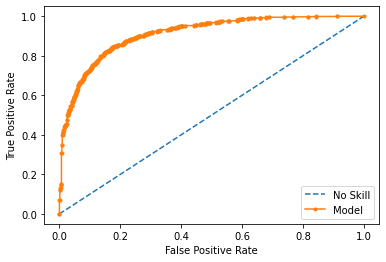

In [83]:
# Fit a basic xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())
bin_preds = clf.predict(xvalid_tfv.tocsc())


# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for simple XGBoost on TFIDF on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)

Strangely, XGBoost didn't do as well on TF-IDF features as logistic regression.

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:33] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple XGBoost on TF-IDF SVD features on _raw data.
Model Log-loss: 0.424 
Model F1 score: 0.758 
Model Accuracy score: 0.714 
Naive ROC AUC=0.500
Model ROC AUC=0.894


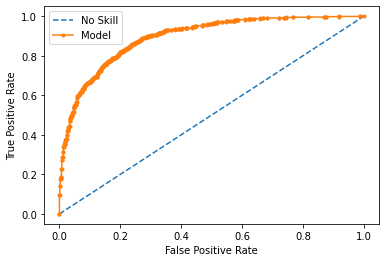

In [33]:
# Fitting a simple xgboost on tf-idf svd features with default parameters
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)
bin_preds = clf.predict(xvalid_svd_scl)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for simple XGBoost on TF-IDF SVD features on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:43:48] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple XGBoost on TF-IDF SVD (with common hyperparams) features on _raw data.
Model Log-loss: 0.396 
Model F1 score: 0.841 
Model Accuracy score: 0.815 
Naive ROC AUC=0.500
Model ROC AUC=0.902


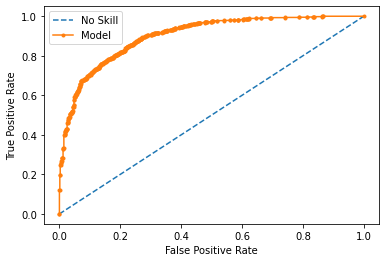

In [34]:
# Fit a basic xgboost on more common hyperparams for tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)
bin_preds = clf.predict(xvalid_svd)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for simple XGBoost on TF-IDF SVD (with common hyperparams) features on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)

On TF-IDF SVD unscaled features, XGBoost does not improve.  

What about on scaled features?

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:44:12] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on _raw data.
Model Log-loss: 0.396 
Model F1 score: 0.841 
Model Accuracy score: 0.815 
Naive ROC AUC=0.500
Model ROC AUC=0.902


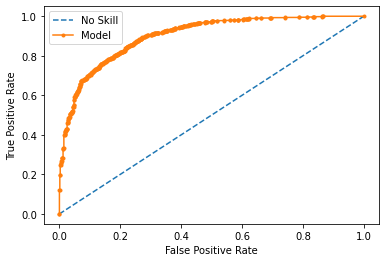

In [35]:
# Fit a basic xgboost on SCALED tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)
bin_preds = clf.predict(xvalid_svd_scl)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for simple XGBoost on Scaled TF-IDF SVD (with common hyperparams) features on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)

So, on Scaled TF-IDF SVD features, XGboost does very similarly.  

But wait!  We haven't done any tuning of hyperparameters yet.

# Improve all those models with some grid search optimization  
First, we can define a scoring metric for automation.  Log-loss will suffice for now, as it was represented the other metrics and seemed to be more sensitive.

In [24]:
basic_scorer = metrics.make_scorer(log_loss, greater_is_better=False, needs_proba=True)

Since we applied svd and scaling to two different sets (TF-IDF and SVD), this seems like it has potential for a pipeline approach

In [25]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize a standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here.
lr_model = LogisticRegression()

# Create the Logistic Regression pipeline 
clf_lr = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

#Set up the parameter grid
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [41]:
# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=4)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we could use the full data here because of CV, but probably even better integrity if we reserve Validation set
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  46 out of  48 | elapsed: 14.0min remaining:   36.6s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 14.1min finished
C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_enc

[07:36:19] WARNING: ..\src\learner.cc:576: 
Parameters: { "lr__C", "lr__penalty", "svd__n_components" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best score: -0.401
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l1'
	svd__n_components: 120


 (results summary)

In [42]:
#Now try optimizing Naive Bayes

nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0829s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Best score: -0.355
Best parameters set:
	nb__alpha: 0.1


# Pretrained Models

In [84]:
# Some set-up # We can limit the GloVe data to our total vocabulary in question to avoid some encoding issues from glove
#total_vocabulary = set(word for headline in data for word in headline)

# GloVe vectors from here:
http://www-nlp.stanford.edu/data/glove.840B.300d.zip
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014.   
GloVe: Global Vectors for Word Representation. 

In [26]:
# load the GloVe vectors in a dictionary:
GLOVE_PATH = 'E:\Downloads\glove.840B.300d/glove.840B.300d.txt'
# class IncrementalDecoder(codecs.IncrementalDecoder):
#     def decode(self, input, final=False):
#         return codecs.charmap_decode(input,self.errors,decoding_table)[0]


'''with open('glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector'''

embeddings_index = {}
with open(GLOVE_PATH, 'rb') as f:
    for line in tqdm(f):
        #print(line)
        parts = line.split()
        word = parts[0].decode('utf-8')
        try:
            coefs = np.asarray(parts[1:], dtype=np.float32)
        except BaseException as err:
            print(err)
            print(parts[0:10])
        embeddings_index[word] = coefs
    #f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196017it [03:40, 9954.22it/s] 

Found 2196016 word vectors.


In [27]:
# Found 2196016 word vectors.
#parts

In [28]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()#.decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [29]:
#original, non-looped
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 1750/1750 [00:03<00:00, 475.10it/s]


In [30]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [90]:
# if not SINGLE_SOURCE:
#     # create sentence vectors using the above function for training and validation set
#     glove_sets = {}
#     for i in range(len(suffixes)):
#         xtrain, xvalid, ytrain, yvalid = select_split(splits[i])
#         xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
#         xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]
#         glove_sets[splits[i]] = [xtrain_glove, xvalid_glove]

In [91]:
# if not SINGLE_SOURCE:
#     for i in range(len(suffixes)):
#         xtrain_glovet = glove_sets[splits[i]][0]
#         xvalid_glovet = glove_sets[splits[i]][1]
#         xtrain_glovet = np.array(xtrain_glovet)
#         xvalid_glovet = np.array(xvalid_glovet)
#         glove_sets[splits[i]][0] = xtrain_glovet
#         glove_sets[splits[i]][1] = xvalid_glovet

Check the performance of xgboost on glove features:`

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:49:11] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for simple XGBoost on glove features on _raw data.
Model Log-loss: 0.500 
Model F1 score: 0.818 
Model Accuracy score: 0.787 
Naive ROC AUC=0.500
Model ROC AUC=0.865


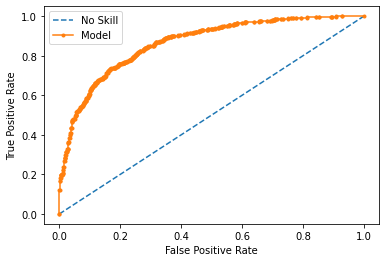

In [95]:
# Fit a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10)#, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)
bin_preds = clf.predict(xvalid_glove)


# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for simple XGBoost on glove features on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)

C:\Users\Eric\anaconda3\envs\learn-env\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:50:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores for slightly more tuned XGBoost on glove features on _raw data.
Model Log-loss: 0.440 
Model F1 score: 0.833 
Model Accuracy score: 0.805 
Naive ROC AUC=0.500
Model ROC AUC=0.885


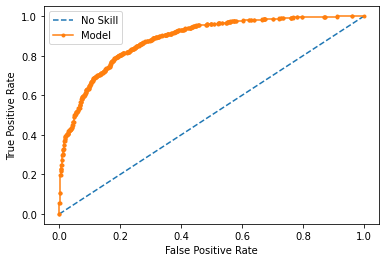

In [96]:
# Fit a slightly less simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1) #silent=False
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)
bin_preds = clf.predict(xvalid_glove)

# print ("logloss: %0.3f " % log_loss(yvalid, predictions))
# print ("f1 score: %0.3f " % f1_score(yvalid, bin_preds))
# print ("Accuracy score: %0.3f " % accuracy_score(yvalid, bin_preds))

print('Scores for slightly more tuned XGBoost on glove features on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)

In [94]:
# a simple tuning of parameters can improve xgboost score on GloVe features!
#but we can tune even more to improve further

In [101]:
xgb_model.get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'enable_categorical', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [43]:
'''#Now try optimizing Naive Bayes

nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))'''

'#Now try optimizing Naive Bayes\n\nnb_model = MultinomialNB()\n\n# Create the pipeline \nclf = pipeline.Pipeline([(\'nb\', nb_model)])\n\n# parameter grid\nparam_grid = {\'nb__alpha\': [0.001, 0.01, 0.1, 1, 10, 100]}\n\n# Initialize Grid Search Model\nmodel = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,\n                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)\n\n# Fit Grid Search Model\nmodel.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. \nprint("Best score: %0.3f" % model.best_score_)\nprint("Best parameters set:")\nbest_parameters = model.best_estimator_.get_params()\nfor param_name in sorted(param_grid.keys()):\n    print("\t%s: %r" % (param_name, best_parameters[param_name]))'

In [ ]:
#Now try optimizing XGBoost a bit

xgb_model = xgb.XGBClassifier()

# Create the pipeline 
clf = pipeline.Pipeline([('xgb', xgb_model)])

# parameter grid
'''max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1'''
param_grid = {"xgb__learning_rate"    : [0.05, 0.10, 0.20] ,
 "xgb__max_depth"        : [ 6, 8, 10],
 "xgb__min_child_weight" : [ 1, 3, 6 ],
 "xgb__gamma"            : [ 0.0, 0.1, 0.2 , 0.4 ],
 "xgb__colsample_bytree" : [ 0.3, 0.5, 0.7] }                

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=basic_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_glove, ytrain) 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

###probably need to set features
predictions = clf.predict_proba(xvalid_glove)
bin_preds = clf.predict(xvalid_glove)
print('Scores for gridsearched XGBoost on glove features on {} data.'.format(splits[suffix]))
score_report(yvalid, predictions, bin_preds)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 2 folds for each of 324 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.2min
[Paralle

# Deep Learning  
LSTM and dense network
ADD GRU

In [ ]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [45]:
# # looped if we want to inspect the different cleaning levels
# glovescls = {}
# for i in range(len(suffixes)):
#     xtrain_glovel, xvalid_glovel = glove_sets[splits[i]][0], glove_sets[splits[i]][1]
    
#     scl = preprocessing.StandardScaler()
#     xtrain_glove_scll = scl.fit_transform(xtrain_glove)
#     xvalid_glove_scll = scl.transform(xvalid_glove)
    
#     glovescls[splits[i]] = [xtrain_glove_scll, xvalid_glove_scll]


In [51]:
display(xtrain_glove_scl.shape)
xvalid_glove_scl.shape

(15744, 300)

(1750, 300)

In [52]:
ytrain.shape

(15744,)

In [53]:
ytrain

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [54]:
yvalid.shape

(1750,)

In [ ]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [ ]:
display(ytrain_enc.shape)
display(yvalid_enc.shape)
ytrain_enc

In [120]:
if not SINGLE_SOURCE:
    #looping through the different cleaning levels, if necessary
    for i in range(len(suffixes)):
        # create a 3 layer sequential neural net
        model = Sequential()

        model.add(Dense(300, input_dim=300, activation='relu'))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(300, activation='relu'))
        model.add(Dropout(0.3))
        model.add(BatchNormalization())

        model.add(Dense(2))
        model.add(Activation('softmax'))

        # compile the model
        model.compile(loss='binary_crossentropy', optimizer='adam')

        xtrain_glove_scll, xvalid_glove_scll = glovescls[splits[i]][0], glovescls[splits[i]][1]
        print('for set {}'.format(splits[i]))
        model.fit(xtrain_glove_scll, y=ytrain_enc, batch_size=64, 
              epochs=20, verbose=1, 
              validation_data=(xvalid_glove_scll, yvalid_enc))

for set _raw
Epoch 1/20
246/246 [==============================] - 1s 5ms/step - loss: 0.6839 - val_loss: 0.6835
Epoch 2/20
246/246 [==============================] - 1s 5ms/step - loss: 0.6837 - val_loss: 0.6844
Epoch 3/20
246/246 [==============================] - 1s 4ms/step - loss: 0.6837 - val_loss: 0.6835
Epoch 4/20
246/246 [==============================] - 1s 4ms/step - loss: 0.6838 - val_loss: 0.6837
Epoch 5/20
246/246 [==============================] - 1s 4ms/step - loss: 0.6837 - val_loss: 0.6834
Epoch 6/20
246/246 [==============================] - 1s 4ms/step - loss: 0.6836 - val_loss: 0.6835
Epoch 7/20
246/246 [==============================] - 1s 4ms/step - loss: 0.6835 - val_loss: 0.6834
Epoch 8/20
246/246 [==============================] - 1s 4ms/step - loss: 0.6837 - val_loss: 0.6834
Epoch 9/20
246/246 [==============================] - 1s 4ms/step - loss: 0.6838 - val_loss: 0.6835
Epoch 10/20
246/246 [==============================] - 1s 4ms/step - loss: 0.6837 - val

In [133]:
# create a 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')



In [134]:
#not sure what i was doing here - this dimensionality doesn't work and we want scaled data anyway, as in the next cell
# model.fit(xtrain, y=ytrain, batch_size=64, 
#           epochs=5, verbose=1, 
#           validation_data=(xvalid_glove_scl, yvalid_enc))

In [135]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=8, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Epoch 1/10
246/246 [==============================] - 1s 4ms/step - loss: 0.5399 - val_loss: 0.4248
Epoch 2/10
246/246 [==============================] - 1s 4ms/step - loss: 0.4087 - val_loss: 0.4053
Epoch 3/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3781 - val_loss: 0.3916
Epoch 4/10
246/246 [==============================] - 1s 3ms/step - loss: 0.3553 - val_loss: 0.3924
Epoch 5/10
246/246 [==============================] - 1s 3ms/step - loss: 0.3359 - val_loss: 0.3981
Epoch 6/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3168 - val_loss: 0.3947
Epoch 7/10
246/246 [==============================] - 1s 4ms/step - loss: 0.3034 - val_loss: 0.4066
Epoch 8/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2871 - val_loss: 0.4162
Epoch 9/10
246/246 [==============================] - 1s 3ms/step - loss: 0.2747 - val_loss: 0.4054
Epoch 10/10
246/246 [==============================] - 1s 4ms/step - loss: 0.2571 - val_loss: 0.4304

In [138]:
# #predictions = model.predict_proba(xvalid_glove)
# bin_preds = model.predict(xvalid_glove)
# print('Scores for gridsearched XGBoost on glove features on {} data.'.format(splits[suffix]))
# score_report(yvalid, predictions, bin_preds)

So we can see that past epoch 4, we are overtraining.  Still, this is very quick and does rather well.  Let's tune the model architecture a bit and try again.

In [139]:
# create a 8 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(800, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [140]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=15, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Epoch 1/15
246/246 [==============================] - 3s 13ms/step - loss: 0.7227 - val_loss: 0.4980
Epoch 2/15
246/246 [==============================] - 3s 11ms/step - loss: 0.5089 - val_loss: 0.4250
Epoch 3/15
246/246 [==============================] - 3s 11ms/step - loss: 0.4480 - val_loss: 0.4046
Epoch 4/15
246/246 [==============================] - 3s 11ms/step - loss: 0.4185 - val_loss: 0.3972
Epoch 5/15
246/246 [==============================] - 3s 11ms/step - loss: 0.3996 - val_loss: 0.3879
Epoch 6/15
246/246 [==============================] - 3s 11ms/step - loss: 0.3852 - val_loss: 0.3855
Epoch 7/15
246/246 [==============================] - 3s 11ms/step - loss: 0.3666 - val_loss: 0.3874
Epoch 8/15
246/246 [==============================] - 3s 11ms/step - loss: 0.3567 - val_loss: 0.3903
Epoch 9/15
246/246 [==============================] - 3s 11ms/step - loss: 0.3448 - val_loss: 0.3803
Epoch 10/15
246/246 [==============================] - 3s 11ms/step - loss: 0.3290 - val_lo

In [141]:
suffixes

['_raw', '_cln', '_lem', '_stm']

In [ ]:
xtrain = xtrain_raw
xvalid = xvalid_raw

xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [154]:
# testing 8 layer dense neural net with cleaned/stem/lem data
#original, non-looped
# create a 8 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(800, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(400, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(30, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam')

model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=15, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

100%|██████████| 1750/1750 [00:01<00:00, 1145.34it/s]


Epoch 1/15
246/246 [==============================] - 3s 12ms/step - loss: 0.8732 - val_loss: 0.6764
Epoch 2/15
246/246 [==============================] - 3s 11ms/step - loss: 0.6866 - val_loss: 0.6271
Epoch 3/15
246/246 [==============================] - 3s 12ms/step - loss: 0.5907 - val_loss: 0.5420
Epoch 4/15
246/246 [==============================] - 3s 11ms/step - loss: 0.5322 - val_loss: 0.4630
Epoch 5/15
246/246 [==============================] - 3s 11ms/step - loss: 0.4848 - val_loss: 0.4292
Epoch 6/15
246/246 [==============================] - 3s 11ms/step - loss: 0.4622 - val_loss: 0.4168
Epoch 7/15
246/246 [==============================] - 3s 11ms/step - loss: 0.4489 - val_loss: 0.4170
Epoch 8/15
246/246 [==============================] - 3s 11ms/step - loss: 0.4341 - val_loss: 0.4075
Epoch 9/15
246/246 [==============================] - 3s 11ms/step - loss: 0.4255 - val_loss: 0.4045
Epoch 10/15
246/246 [==============================] - 3s 11ms/step - loss: 0.4127 - val_lo

In [64]:
'''You need to keep on tuning the parameters of the neural network, add more layers, 
increase dropout to get better results. Here, I'm just showing that its fast to implement and run and gets better 
result than xgboost without any optimization :)

To move further, i.e. with LSTMs we need to tokenize the text data'''

"You need to keep on tuning the parameters of the neural network, add more layers, \nincrease dropout to get better results. Here, I'm just showing that its fast to implement and run and gets better \nresult than xgboost without any optimization :)\n\nTo move further, i.e. with LSTMs we need to tokenize the text data"

# LSTMs
In order to work with these, we should tokenize the text data.

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [161]:
# A basic RNN with glove embeddings and two dense layers - batch size 512
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(SimpleRNN(100))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
# model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
#           verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=20, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Epoch 1/20
31/31 [==============================] - 7s 215ms/step - loss: 0.7071 - val_loss: 0.6449
Epoch 2/20
31/31 [==============================] - 6s 209ms/step - loss: 0.6162 - val_loss: 0.5683
Epoch 3/20
31/31 [==============================] - 6s 203ms/step - loss: 0.5760 - val_loss: 0.5519
Epoch 4/20
31/31 [==============================] - 6s 205ms/step - loss: 0.5880 - val_loss: 0.5636
Epoch 5/20
31/31 [==============================] - 6s 206ms/step - loss: 0.5579 - val_loss: 0.5340
Epoch 6/20
31/31 [==============================] - 6s 201ms/step - loss: 0.5449 - val_loss: 0.5510
Epoch 7/20
31/31 [==============================] - 6s 202ms/step - loss: 0.5370 - val_loss: 0.5273
Epoch 8/20
31/31 [==============================] - 6s 201ms/step - loss: 0.5374 - val_loss: 0.5362
Epoch 9/20
31/31 [==============================] - 6s 203ms/step - loss: 0.5307 - val_loss: 0.5320
Epoch 10/20
31/31 [==============================] - 6s 203ms/step - loss: 0.5299 - val_loss: 0.5180

In [160]:
# A basic RNN with glove embeddings and two dense layers - change batch size to 64 not 512
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(SimpleRNN(100))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.7))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
# model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
#           verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])
model.fit(xtrain_pad, y=ytrain_enc, batch_size=64, epochs=20, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Epoch 1/20
246/246 [==============================] - 10s 41ms/step - loss: 0.6733 - val_loss: 0.6386
Epoch 2/20
246/246 [==============================] - 10s 39ms/step - loss: 0.5959 - val_loss: 0.5578
Epoch 3/20
246/246 [==============================] - 10s 40ms/step - loss: 0.5863 - val_loss: 0.5460
Epoch 4/20
246/246 [==============================] - 10s 40ms/step - loss: 0.5816 - val_loss: 0.5456
Epoch 5/20
246/246 [==============================] - 10s 39ms/step - loss: 0.5837 - val_loss: 0.6419
Epoch 6/20
246/246 [==============================] - 10s 39ms/step - loss: 0.6279 - val_loss: 0.6142
Epoch 7/20
246/246 [==============================] - 10s 39ms/step - loss: 0.6074 - val_loss: 0.5702
Epoch 8/20
246/246 [==============================] - 10s 39ms/step - loss: 0.5799 - val_loss: 0.6040
Epoch 9/20
246/246 [==============================] - 10s 39ms/step - loss: 0.5765 - val_loss: 0.6091
Epoch 10/20
246/246 [==============================] - 10s 40ms/step - loss: 0.581

Interesting, reducing the batch size made loss worse.  There were seemingly not enough samples in each batch to settle in on one gradient direction.

Let's implement some early stopping going forward.

In [71]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
31/31 [==============================] - 85s 3s/step - loss: 0.6705 - val_loss: 0.5380
Epoch 2/100
31/31 [==============================] - 85s 3s/step - loss: 0.5653 - val_loss: 0.4998
Epoch 3/100
31/31 [==============================] - 86s 3s/step - loss: 0.5294 - val_loss: 0.4684
Epoch 4/100
31/31 [==============================] - 86s 3s/step - loss: 0.5121 - val_loss: 0.4940
Epoch 5/100
31/31 [==============================] - 87s 3s/step - loss: 0.5103 - val_loss: 0.4747
Epoch 6/100
31/31 [==============================] - 87s 3s/step - loss: 0.4974 - val_loss: 0.4581
Epoch 7/100
31/31 [==============================] - 87s 3s/step - loss: 0.4794 - val_loss: 0.4381
Epoch 8/100
31/31 [==============================] - 87s 3s/step - loss: 0.4639 - val_loss: 0.4410
Epoch 9/100
31/31 [==============================] - 88s 3s/step - loss: 0.4645 - val_loss: 0.4153
Epoch 10/100
31/31 [==============================] - 88s 3s/step - loss: 0.4399 - val_loss: 0.4259
Epoch 11/

In [72]:
'''One question could be: why do i use so much dropout? Well, fit the model with no or little dropout and you will that it starts to overfit :)

Let's see if Bi-directional LSTM can give us better results. Its a piece of cake to do it with Keras :)'''

"One question could be: why do i use so much dropout? Well, fit the model with no or little dropout and you will that it starts to overfit :)\n\nLet's see if Bi-directional LSTM can give us better results. Its a piece of cake to do it with Keras :)"

In [73]:
# A bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/50
31/31 [==============================] - 184s 6s/step - loss: 0.6742 - val_loss: 0.5718
Epoch 2/50
31/31 [==============================] - 187s 6s/step - loss: 0.5806 - val_loss: 0.5213
Epoch 3/50
31/31 [==============================] - 195s 6s/step - loss: 0.5275 - val_loss: 0.4821
Epoch 4/50
31/31 [==============================] - 200s 6s/step - loss: 0.5040 - val_loss: 0.5003
Epoch 5/50
31/31 [==============================] - 204s 7s/step - loss: 0.4970 - val_loss: 0.5001
Epoch 6/50
31/31 [==============================] - 211s 7s/step - loss: 0.4772 - val_loss: 0.4459
Epoch 7/50
31/31 [==============================] - 213s 7s/step - loss: 0.4685 - val_loss: 0.4453
Epoch 8/50
31/31 [==============================] - 216s 7s/step - loss: 0.4577 - val_loss: 0.4370
Epoch 9/50
31/31 [==============================] - 216s 7s/step - loss: 0.4387 - val_loss: 0.4206
Epoch 10/50
31/31 [==============================] - 216s 7s/step - loss: 0.4280 - val_loss: 0.4233
Epoch 11/

In [164]:
# A bidirectional LSTM with glove embeddings and three dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/50
31/31 [==============================] - 181s 6s/step - loss: 0.7341 - val_loss: 0.6877
Epoch 2/50
31/31 [==============================] - 213s 7s/step - loss: 0.6937 - val_loss: 0.6842
Epoch 3/50
31/31 [==============================] - 202s 7s/step - loss: 0.6784 - val_loss: 0.6287
Epoch 4/50
31/31 [==============================] - 199s 6s/step - loss: 0.6381 - val_loss: 0.6363
Epoch 5/50
31/31 [==============================] - 203s 7s/step - loss: 0.5937 - val_loss: 0.5179
Epoch 6/50
31/31 [==============================] - 209s 7s/step - loss: 0.5487 - val_loss: 0.5148
Epoch 7/50
31/31 [==============================] - 205s 7s/step - loss: 0.5196 - val_loss: 0.4838
Epoch 8/50
31/31 [==============================] - 206s 7s/step - loss: 0.5109 - val_loss: 0.4649
Epoch 9/50
31/31 [==============================] - 207s 7s/step - loss: 0.4930 - val_loss: 0.4546
Epoch 10/50
31/31 [==============================] - 208s 7s/step - loss: 0.4859 - val_loss: 0.4494
Epoch 11/

In [165]:
# A two-layer bidirectional LSTM with glove embeddings and three dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model.add(RepeatVector(2)) # Repeat Vector
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=50, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/50
31/31 [==============================] - 237s 8s/step - loss: 0.7264 - val_loss: 0.6906
Epoch 2/50
31/31 [==============================] - 239s 8s/step - loss: 0.6983 - val_loss: 0.6897
Epoch 3/50
31/31 [==============================] - 239s 8s/step - loss: 0.6865 - val_loss: 0.6885
Epoch 4/50
31/31 [==============================] - 242s 8s/step - loss: 0.6729 - val_loss: 0.6312
Epoch 5/50
31/31 [==============================] - 243s 8s/step - loss: 0.6126 - val_loss: 0.5258
Epoch 6/50
31/31 [==============================] - 244s 8s/step - loss: 0.5591 - val_loss: 0.4891
Epoch 7/50
31/31 [==============================] - 245s 8s/step - loss: 0.5309 - val_loss: 0.5021
Epoch 8/50
31/31 [==============================] - 244s 8s/step - loss: 0.5154 - val_loss: 0.4924
Epoch 9/50
31/31 [==============================] - 245s 8s/step - loss: 0.5038 - val_loss: 0.4989


In [166]:
'''Pretty close! Lets try two layers of GRU:'''

'Pretty close! Lets try two layers of GRU:'

In [167]:
# Two layer GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
31/31 [==============================] - 175s 6s/step - loss: 0.6771 - val_loss: 0.6027
Epoch 2/100
31/31 [==============================] - 173s 6s/step - loss: 0.6044 - val_loss: 0.5038
Epoch 3/100
31/31 [==============================] - 173s 6s/step - loss: 0.5476 - val_loss: 0.5081
Epoch 4/100
31/31 [==============================] - 172s 6s/step - loss: 0.5209 - val_loss: 0.4684
Epoch 5/100
31/31 [==============================] - 171s 6s/step - loss: 0.5039 - val_loss: 0.4781
Epoch 6/100
31/31 [==============================] - 171s 6s/step - loss: 0.4859 - val_loss: 0.4347
Epoch 7/100
31/31 [==============================] - 171s 6s/step - loss: 0.4612 - val_loss: 0.4226
Epoch 8/100
31/31 [==============================] - 171s 6s/step - loss: 0.4493 - val_loss: 0.4430
Epoch 9/100
31/31 [==============================] - 171s 6s/step - loss: 0.4489 - val_loss: 0.4428
Epoch 10/100
31/31 [==============================] - 171s 6s/step - loss: 0.4308 - val_loss: 0.4057

In [168]:
# Two layer GRU with glove embeddings and three dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
31/31 [==============================] - 171s 6s/step - loss: 0.6814 - val_loss: 0.6107
Epoch 2/100
31/31 [==============================] - 170s 5s/step - loss: 0.6104 - val_loss: 0.5723
Epoch 3/100
31/31 [==============================] - 170s 5s/step - loss: 0.5669 - val_loss: 0.5317
Epoch 4/100
31/31 [==============================] - 169s 5s/step - loss: 0.5220 - val_loss: 0.4677
Epoch 5/100
31/31 [==============================] - 170s 5s/step - loss: 0.4930 - val_loss: 0.4536
Epoch 6/100
31/31 [==============================] - 169s 5s/step - loss: 0.4650 - val_loss: 0.4352
Epoch 7/100
31/31 [==============================] - 169s 5s/step - loss: 0.4677 - val_loss: 0.4320
Epoch 8/100
31/31 [==============================] - 171s 6s/step - loss: 0.4421 - val_loss: 0.4148
Epoch 9/100
31/31 [==============================] - 169s 5s/step - loss: 0.4331 - val_loss: 0.4236
Epoch 10/100
31/31 [==============================] - 169s 5s/step - loss: 0.4279 - val_loss: 0.4225

In [ ]:
# 2-layer Bidirectional GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
#model.add(RepeatVector(2)) # Repeat Vector
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
31/31 [==============================] - 755s 24s/step - loss: 0.6975 - val_loss: 0.6003 - ETA: 4:35 - loss: 0.71 - ETA: 4:04 -
Epoch 2/100
31/31 [==============================] - 455s 15s/step - loss: 0.6007 - val_loss: 0.5573
Epoch 3/100
31/31 [==============================] - 449s 14s/step - loss: 0.5553 - val_loss: 0.5212
Epoch 4/100
31/31 [==============================] - 454s 15s/step - loss: 0.5183 - val_loss: 0.4631
Epoch 5/100
31/31 [==============================] - 457s 15s/step - loss: 0.4892 - val_loss: 0.4591
Epoch 6/100
31/31 [==============================] - 461s 15s/step - loss: 0.4758 - val_loss: 0.4313
Epoch 7/100
31/31 [==============================] - 473s 15s/step - loss: 0.4585 - val_loss: 0.4284
Epoch 8/100
31/31 [==============================] - 474s 15s/step - loss: 0.4452 - val_loss: 0.4274
Epoch 9/100
31/31 [==============================] - 470s 15s/step - loss: 0.4270 - val_loss: 0.4120
Epoch 10/100
31/31 [==============================] 

In [ ]:
# single Bidirectional GRU with glove embeddings and four dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
#model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
#model.add(RepeatVector(2)) # Repeat Vector
model.add(Bidirectional(GRU(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

In [ ]:
''' can improve these results even more.  consider stemming/lemmatization? '''

'''NEXT: Put in Apache so we can parallel process
Add other metrics

Add most commonly occuring words in positive/negative reviews
'''

In [ ]:
# Ensembling (probably don't want to go this deep)

In [ ]:
# # this is the main ensembling class. how to use it is in the next cell!
# import numpy as np
# from sklearn.metrics import roc_auc_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold, KFold
# import pandas as pd
# import os
# import sys
# import logging

# logging.basicConfig(
#     level=logging.DEBUG,
#     format="[%(asctime)s] %(levelname)s %(message)s",
#     datefmt="%H:%M:%S", stream=sys.stdout)
# logger = logging.getLogger(__name__)


# class Ensembler(object):
#     def __init__(self, model_dict, num_folds=3, task_type='classification', optimize=roc_auc_score,
#                  lower_is_better=False, save_path=None):
#         """
#         Ensembler init function
#         :param model_dict: model dictionary, see README for its format
#         :param num_folds: the number of folds for ensembling
#         :param task_type: classification or regression
#         :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
#         :param lower_is_better: is lower value of optimization function better or higher
#         :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
#         """

#         self.model_dict = model_dict
#         self.levels = len(self.model_dict)
#         self.num_folds = num_folds
#         self.task_type = task_type
#         self.optimize = optimize
#         self.lower_is_better = lower_is_better
#         self.save_path = save_path

#         self.training_data = None
#         self.test_data = None
#         self.y = None
#         self.lbl_enc = None
#         self.y_enc = None
#         self.train_prediction_dict = None
#         self.test_prediction_dict = None
#         self.num_classes = None

#     def fit(self, training_data, y, lentrain):
#         """
#         :param training_data: training data in tabular format
#         :param y: binary, multi-class or regression
#         :return: chain of models to be used in prediction
#         """

#         self.training_data = training_data
#         self.y = y

#         if self.task_type == 'classification':
#             self.num_classes = len(np.unique(self.y))
#             logger.info("Found %d classes", self.num_classes)
#             self.lbl_enc = LabelEncoder()
#             self.y_enc = self.lbl_enc.fit_transform(self.y)
#             kf = StratifiedKFold(n_splits=self.num_folds)
#             train_prediction_shape = (lentrain, self.num_classes)
#         else:
#             self.num_classes = -1
#             self.y_enc = self.y
#             kf = KFold(n_splits=self.num_folds)
#             train_prediction_shape = (lentrain, 1)

#         self.train_prediction_dict = {}
#         for level in range(self.levels):
#             self.train_prediction_dict[level] = np.zeros((train_prediction_shape[0],
#                                                           train_prediction_shape[1] * len(self.model_dict[level])))

#         for level in range(self.levels):

#             if level == 0:
#                 temp_train = self.training_data
#             else:
#                 temp_train = self.train_prediction_dict[level - 1]

#             for model_num, model in enumerate(self.model_dict[level]):
#                 validation_scores = []
#                 foldnum = 1
#                 for train_index, valid_index in kf.split(self.train_prediction_dict[0], self.y_enc):
#                     logger.info("Training Level %d Fold # %d. Model # %d", level, foldnum, model_num)

#                     if level != 0:
#                         l_training_data = temp_train[train_index]
#                         l_validation_data = temp_train[valid_index]
#                         model.fit(l_training_data, self.y_enc[train_index])
#                     else:
#                         l0_training_data = temp_train[0][model_num]
#                         if type(l0_training_data) == list:
#                             l_training_data = [x[train_index] for x in l0_training_data]
#                             l_validation_data = [x[valid_index] for x in l0_training_data]
#                         else:
#                             l_training_data = l0_training_data[train_index]
#                             l_validation_data = l0_training_data[valid_index]
#                         model.fit(l_training_data, self.y_enc[train_index])

#                     logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

#                     if self.task_type == 'classification':
#                         temp_train_predictions = model.predict_proba(l_validation_data)
#                         self.train_prediction_dict[level][valid_index,
#                         (model_num * self.num_classes):(model_num * self.num_classes) +
#                                                        self.num_classes] = temp_train_predictions

#                     else:
#                         temp_train_predictions = model.predict(l_validation_data)
#                         self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
#                     validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
#                     validation_scores.append(validation_score)
#                     logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
#                                 validation_score)
#                     foldnum += 1
#                 avg_score = np.mean(validation_scores)
#                 std_score = np.std(validation_scores)
#                 logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
#                             avg_score, std_score)

#             logger.info("Saving predictions for level # %d", level)
#             train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
#             train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
#                                         index=False, header=None)

#         return self.train_prediction_dict

#     def predict(self, test_data, lentest):
#         self.test_data = test_data
#         if self.task_type == 'classification':
#             test_prediction_shape = (lentest, self.num_classes)
#         else:
#             test_prediction_shape = (lentest, 1)

#         self.test_prediction_dict = {}
#         for level in range(self.levels):
#             self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
#                                                          test_prediction_shape[1] * len(self.model_dict[level])))
#         self.test_data = test_data
#         for level in range(self.levels):
#             if level == 0:
#                 temp_train = self.training_data
#                 temp_test = self.test_data
#             else:
#                 temp_train = self.train_prediction_dict[level - 1]
#                 temp_test = self.test_prediction_dict[level - 1]

#             for model_num, model in enumerate(self.model_dict[level]):

#                 logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
#                 if level == 0:
#                     model.fit(temp_train[0][model_num], self.y_enc)
#                 else:
#                     model.fit(temp_train, self.y_enc)

#                 logger.info("Predicting Test Level %d. Model # %d", level, model_num)

#                 if self.task_type == 'classification':
#                     if level == 0:
#                         temp_test_predictions = model.predict_proba(temp_test[0][model_num])
#                     else:
#                         temp_test_predictions = model.predict_proba(temp_test)
#                     self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
#                                                                                         self.num_classes] = temp_test_predictions

#                 else:
#                     if level == 0:
#                         temp_test_predictions = model.predict(temp_test[0][model_num])
#                     else:
#                         temp_test_predictions = model.predict(temp_test)
#                     self.test_prediction_dict[level][:, model_num] = temp_test_predictions

#             test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
#             test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
#                                        index=False, header=None)

#         return self.test_prediction_dict

In [ ]:
# # specify the data to be used for every level of ensembling:
# train_data_dict = {0: [xtrain_tfv, xtrain_ctv, xtrain_tfv, xtrain_ctv], 1: [xtrain_glove]}
# test_data_dict = {0: [xvalid_tfv, xvalid_ctv, xvalid_tfv, xvalid_ctv], 1: [xvalid_glove]}

# model_dict = {0: [LogisticRegression(), LogisticRegression(), MultinomialNB(alpha=0.1), MultinomialNB()],

#               1: [xgb.XGBClassifier(silent=True, n_estimators=120, max_depth=7)]}

# ens = Ensembler(model_dict=model_dict, num_folds=3, task_type='classification',
#                 optimize=multiclass_logloss, lower_is_better=True, save_path='')

# ens.fit(train_data_dict, ytrain, lentrain=xtrain_glove.shape[0])
# preds = ens.predict(test_data_dict, lentest=xvalid_glove.shape[0])

In [ ]:
#log_loss(yvalid, preds[1])

In [ ]:
#set up apache spark system to do parallel processing?
#maybe Try to set up amazon resources - possibly overkill/not good for github
## see recommendation systems section - this isn't actually directly applicable - more for recs for a user based on other user's recs
# topic 39 - nlp obvs
#tf-idfs?
#nnetworks with
# word2vec (including gensim) see https://learning.flatironschool.com/courses/1890/pages/using-word2vec?module_item_id=261958
#GloVe for classification - (This is a very good pretrained model)
# word embeddings, 
#sequence models e.g. 
#RNN and 
#lstms, 
#grus, 
#gridsearch for best params,
#ensemble methods - e.g. xgboost on these models
#anything else that is in 
# https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle/comments
'''tfidf
count features
logistic regression
naive bayes
svm
xgboost
grid search
word vectors
LSTM
GRU
Ensembling'''

